**INTRODUCTION**

The Super Bowl period comes with all sorts of traditions that football fans take part in to commemorate the climax of the American Football season. One of the traditionsthat is common is the game of Football Squares, that is a prediction game rewarding those that will get the final score right.

**About Football Squares**

As mentioned in the introduction, Football Squares is a game that rewards  those that will predict the score right,before the game. How does the game work you may ask, the following is the explanation. A 10x10 grid is drawn with the row and column having squares 0 to 9 respect-fully.A row will represent one team whilea column represents another. Each of the grids represents a combination of digits i.e., column 3, row 4 is 3-4. The players will then try to predict what the final score will be between the two teams in-volved. The last digit of each score will represent the home and away teams 


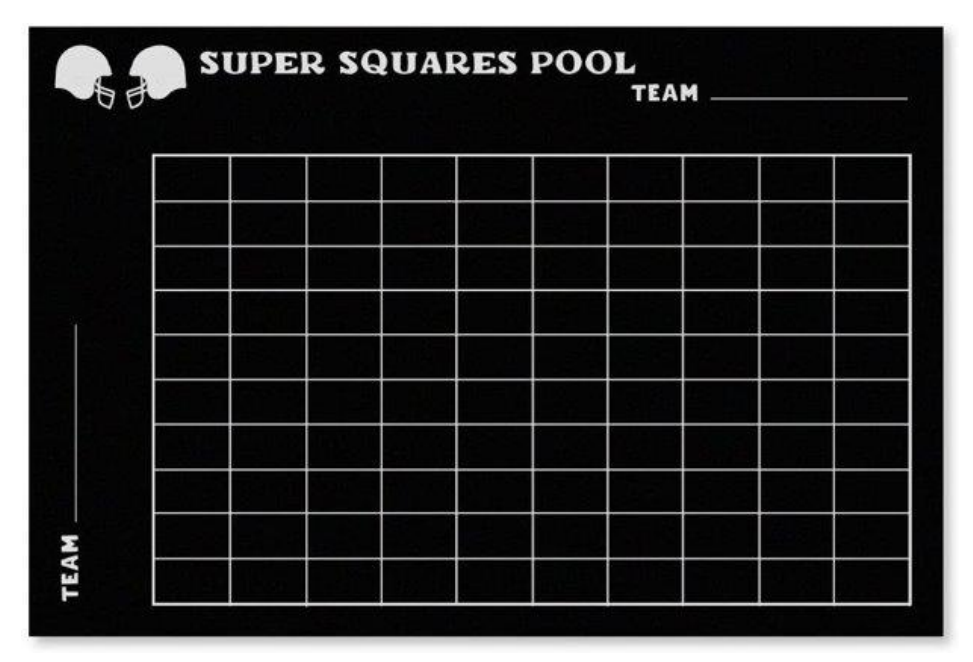

A 10x10 grid is drawn with the row and column having squares 0 to 9 respect-fully.A row will represent one team whilea column represents another. Each of the grids represents a combination of digits i.e., column 3, row 4 is 3-4. The players will then try to predict what the final score will be between the two teams in-volved. The last digit of each score will represent the home and away teams Figure 1: Football Squares Blank Template
3respectfully e.g. the game ending 24-19 will have a winning grid 4-9 (column 4, row 9). Each grid has an amount against it, usually the most sought for grids have a higher amount to bet. The players select their grids beforehand and will write their names against them. When the game is done, the person who puts their name against the correctly predicted square, will win the game and win the prize money.

**Goal of the project**

The goal is to predict which square will be the winner given historic data such as season, home/away team, stadium, Vegas line, etc. This project can be further informative by predicting the top number of squares with probability e.g., the model should be able to predict “the top 5 squares represent 36% of the expected result”.

**ABOUT THE DATA**

Data was collected and scraped from Pro Football Reference (https://www.pro-football-reference.com/). The data collected is from the 1999 to 2021 seasons.






In [24]:
import numpy as np
import pandas as pd

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Read the data
URL = 'https://drive.google.com/file/d/1R0tJytEFRkcZbbSvmaFUIC9pGmkzwXr6/view?usp=sharing'
URL ='https://drive.google.com/uc?id=' + URL.split('/')[-2]
raw_data = pd.read_csv(URL)
raw_data = raw_data.drop(['home_score_ot', 'away_score_ot', 'weather'], axis=1)

raw_data.head()

,id,home_team,away_team,season,week,reg_season,game_date,start_time,game_duration,stadium,...,home_sacks,home_time_of_possession,away_first_downs,away_total_yards,away_turnovers,away_penalties,away_penalty_yards,away_sacks,away_time_of_possession,last_updated
0,1,Tampa Bay Buccaneers,Dallas Cowboys,2021,1,1,2021-09-09,20:20:00,211.0,Raymond James Stadium,...,0,1533,30,451,1,8,55,1,2067,2022-05-19 13:53:39.139843
1,2,Atlanta Falcons,Philadelphia Eagles,2021,1,1,2021-09-12,13:00:00,188.0,Mercedes-Benz Stadium,...,3,1738,24,434,0,14,89,1,1862,2022-05-19 13:53:47.450421
2,3,Buffalo Bills,Pittsburgh Steelers,2021,1,1,2021-09-12,13:00:00,188.0,Highmark Stadium,...,3,1997,16,252,0,5,32,2,1603,2022-05-19 13:53:55.247359
3,4,Carolina Panthers,New York Jets,2021,1,1,2021-09-12,13:00:00,194.0,Bank of America Stadium,...,1,1880,16,252,1,5,30,6,1720,2022-05-19 13:54:03.394831
4,6,Indianapolis Colts,Seattle Seahawks,2021,1,1,2021-09-12,13:00:00,178.0,Lucas Oil Stadium,...,3,2147,18,381,1,7,53,3,1453,2022-05-19 13:54:20.115188


In [25]:
# squares for each quarters
for qt in ['q1', 'q2', 'q3', 'q4']:
  last_digit_home_score = raw_data[f'home_score_{qt}'].apply(str).apply(lambda x: x[-1])
  last_digit_away_score = raw_data[f'away_score_{qt}'].apply(str).apply(lambda x: x[-1])
  square = last_digit_home_score + '-' + last_digit_away_score
  raw_data[f'square_{qt}'] = square
del last_digit_home_score, last_digit_away_score, square

# labeling squares with int values
y = pd.concat([raw_data[f'square_q{i}'] for i in range(1,5)])

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)

for qt in ['q1', 'q2', 'q3', 'q4']:
  raw_data[f'square_{qt}_int'] = le.transform(raw_data[f'square_{qt}'])

# new column for start time
raw_data['start_time'] = pd.to_timedelta(raw_data['start_time']) / np.timedelta64(1,'D')


In [26]:
# new column for the first_possession for home team
raw_data['home_possession'] = 0
raw_data.loc[raw_data['first_possession'] == raw_data['home_team'], 'home_possession'] = 1
del raw_data['first_possession']

# new columns to calculate winning rate of the year
raw_data['home_win'] = 0
cond = raw_data.home_score_final > raw_data.away_score_final
raw_data.loc[cond, 'home_win'] = 1
raw_data['away_win'] = 0
cond = raw_data.home_score_final < raw_data.away_score_final
raw_data.loc[cond, 'away_win'] = 1

# data processing for roof information
roof_mapping = {
    'outdoors': 0,
    'retractable roof (open)': 1,
    'retractable roof (closed)': 2,
    'dome': 3}
raw_data['roof'] = raw_data['roof'].map(roof_mapping)
del roof_mapping

# data processing for surface information
surface_dummy = pd.get_dummies(raw_data['surface'], drop_first=True)
raw_data = pd.concat([raw_data, surface_dummy], axis=1)
del raw_data['surface']
del surface_dummy

seasons = sorted(raw_data.season.unique())[:-1]

In [27]:
# calculate a team's stat of a speficif year 
def team_stat(raw_data, year):
    is_year = (raw_data.season == year)

    data_of_year = raw_data.loc[is_year, :]

    home_columns = [
        'home_first_downs', 'home_total_yards', 'home_turnovers', 'home_penalties',
        'home_penalty_yards', 'home_sacks', 'home_time_of_possession',
        'home_win', 'home_score_q1']
    home_team = data_of_year.loc[:, home_columns]

    home_team.columns = home_team.columns.str.replace('home_', '')
    home_team['team'] = data_of_year['home_team']


    away_columns = [
        'away_first_downs', 'away_total_yards', 'away_turnovers',
        'away_penalties', 'away_penalty_yards', 'away_sacks',
        'away_time_of_possession',
        'away_win', 'away_score_q1']

    away_team = data_of_year.loc[:, away_columns]

    away_team.columns = away_team.columns.str.replace('away_', '')
    away_team['team'] = data_of_year['away_team']

    team_table = pd.concat([home_team, away_team], axis =0)
    team_stat_year = pd.pivot_table(team_table, index='team', aggfunc=np.mean).add_prefix('avg_')

    return team_stat_year

team_stats = []

for season in seasons:
  teamstat_ = team_stat(raw_data, season)
  teamstat_['season'] = season + 1 # to add the previous average stats
  team_stats.append(teamstat_)

team_stats = pd.concat(team_stats)
team_stats_season = team_stats['season']
team_stats = team_stats.reset_index()

home_team_info = team_stats.add_prefix('home_')
away_team_info = team_stats.add_prefix('away_')

raw_data = raw_data.merge(home_team_info, how='left', left_on=['home_team', 'season'], right_on=['home_team', 'home_season'])
raw_data = raw_data.merge(away_team_info, how='left', left_on=['away_team', 'season'], right_on=['away_team', 'away_season'])
raw_data = raw_data.sort_index(axis = 1)

del team_stats, team_stats_season, teamstat_, season, seasons, home_team_info, away_team_info, cond

In [28]:
# filling N/A in vegas line with average value
raw_data['vegas_line'] = raw_data['vegas_line'].fillna(value=raw_data['vegas_line'].mean())

# removing the data from season 1999 since it doesn't have the data from the previous year
raw_data = raw_data.dropna()

columns = [
    # information available before the game starts
    'season', 'home_possession', 'over_under', 'roof',
    'sportturf', 'astroplay', 'astroturf', 'dessograss', 'fieldturf', 'grass', 'matrixturf',
    'vegas_line', 'start_time',

    # average stats from the previous year
    'away_avg_first_downs', 'away_avg_penalties',
    'away_avg_penalty_yards', 'away_avg_sacks', 'away_avg_score_q1',
    'away_avg_time_of_possession', 'away_avg_total_yards',
    'away_avg_turnovers', 'away_avg_win',
    'home_avg_first_downs', 'home_avg_penalties',
    'home_avg_penalty_yards', 'home_avg_sacks', 'home_avg_score_q1',
    'home_avg_time_of_possession', 'home_avg_total_yards',
    'home_avg_turnovers', 'home_avg_win',

    # game results
    'home_score_q1', 'home_score_q2', 'home_score_q3', 'home_score_q4',
    'away_score_q1', 'away_score_q2', 'away_score_q3', 'away_score_q4',
    'square_q1_int', 'square_q2_int', 'square_q3_int', 'square_q4_int',
]

df = raw_data[columns].copy()

x_columns = [
    # information availabe before the game starts
    'season', 'home_possession', 'over_under', 'roof',
    'sportturf', 'astroplay', 'astroturf', 'dessograss', 'fieldturf', 'grass', 'matrixturf',
    'vegas_line', 'start_time',
    # average stats from the previous year
    'away_avg_first_downs', 'away_avg_penalties',
    'away_avg_penalty_yards', 'away_avg_sacks', 'away_avg_score_q1',
    'away_avg_time_of_possession', 'away_avg_total_yards',
    'away_avg_turnovers', 'away_avg_win',
    'home_avg_first_downs', 'home_avg_penalties',
    'home_avg_penalty_yards', 'home_avg_sacks', 'home_avg_score_q1',
    'home_avg_time_of_possession', 'home_avg_total_yards',
    'home_avg_turnovers', 'home_avg_win',
    # game results
    'home_score_q1', 'home_score_q2', 'home_score_q3',
    'away_score_q1', 'away_score_q2', 'away_score_q3',
    'square_q1_int', 'square_q2_int', 'square_q3_int'
]

y_columns = ['square_q1_int', 'square_q2_int', 'square_q3_int', 'square_q4_int']

X = df[x_columns]
y = df[y_columns]

In [29]:

# Split data to test/train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=10)

X_columns_q1 = ['season', 'home_possession', 'over_under', 'roof', 'sportturf',
       'astroplay', 'astroturf', 'dessograss', 'fieldturf', 'grass',
       'matrixturf', 'vegas_line', 'start_time', 'away_avg_first_downs',
       'away_avg_penalties', 'away_avg_penalty_yards', 'away_avg_sacks',
       'away_avg_score_q1', 'away_avg_time_of_possession',
       'away_avg_total_yards', 'away_avg_turnovers', 'away_avg_win',
       'home_avg_first_downs', 'home_avg_penalties', 'home_avg_penalty_yards',
       'home_avg_sacks', 'home_avg_score_q1', 'home_avg_time_of_possession',
       'home_avg_total_yards', 'home_avg_turnovers', 'home_avg_win']

X_train_q1 = X_train[X_columns_q1]
X_test_q1 = X_test[X_columns_q1]

y_train_q1 = y_train['square_q1_int']
y_test_q1 = y_test['square_q1_int']


# grid search cv to find the best models and parameters
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params': {'C': [1, 10, 20]}
    },
    'logistic_regession': {
        'model': LogisticRegression(),
        'params': {'C': [1, 5, 10]}
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {'n_estimators': [30, 50, 70]}
    }
}

scores = []
for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train_q1, y_train_q1)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

model_table = pd.DataFrame(scores)


In [30]:
print(model_table)

                model  best_score           best_params
0                 svm    0.181689              {'C': 1}
1  logistic_regession    0.188185             {'C': 10}
2       random_forest    0.150017  {'n_estimators': 70}


best model is logistic regression with C:10

We will use the best model and parameter

In [35]:
# 1st quarter
from sklearn.linear_model import LogisticRegression
clf_q1 = LogisticRegression(C=10)
clf_q1.fit(X_train_q1, y_train_q1)

result = {}
result['q1_score'] = clf_q1.score(X_test_q1, y_test_q1)


# 2nd quarter
# include the result from the 1st quarter
X_columns_q2 = X_columns_q1 + ['home_score_q1', 'away_score_q1', 'square_q1_int']

X_train_q2 = X_train[X_columns_q2]
X_test_q2 = X_test[X_columns_q2]

y_train_q2 = y_train['square_q2_int']
y_test_q2 = y_test['square_q2_int']

clf_q2 = LogisticRegression(C=10)
clf_q2.fit(X_train_q2, y_train_q2)
result['q2_score'] = clf_q2.score(X_test_q2, y_test_q2)


# 3rd quarter
# include the result from the 2nd quarter
X_columns_q3 = X_columns_q2 + ['home_score_q2', 'away_score_q2', 'square_q2_int']

X_train_q3 = X_train[X_columns_q3]
X_test_q3 = X_test[X_columns_q3]

y_train_q3 = y_train['square_q3_int']
y_test_q3 = y_test['square_q3_int']

clf_q3 = LogisticRegression(C=10)
clf_q3.fit(X_train_q3, y_train_q3)
result['q3_score'] = clf_q3.score(X_test_q3, y_test_q3)

# 4th quarter
# include the result from the 3nd quarter
X_columns_q4 = X_columns_q3 + ['home_score_q3', 'away_score_q3', 'square_q3_int']

X_train_q4 = X_train[X_columns_q4]
X_test_q4 = X_test[X_columns_q4]

y_train_q4 = y_train['square_q4_int']
y_test_q4 = y_test['square_q4_int']

clf_q4 = LogisticRegression(C=10)
clf_q4.fit(X_train_q4, y_train_q4)
result['q4_score'] = clf_q4.score(X_test_q4, y_test_q4)


In [36]:
print(result)

{'q1_score': 0.19195402298850575, 'q2_score': 0.08160919540229886, 'q3_score': 0.05057471264367816, 'q4_score': 0.03793103448275862}


In [37]:
# function to calculate the top 5 square with the possibility given the data (row)
square_dic = {}

for v in le.classes_:
        k = int(v[0] + v[2])
        square_dic[k] = v

def return_top5(quarter, row):

    clfs = [clf_q1, clf_q2, clf_q3, clf_q4]
    clf = clfs[quarter - 1]

    X = row.values.reshape(1, -1)
    pred = clf.predict_proba(X)

    result_ind = [square_dic[k] for k in clf.classes_]
    result = pd.DataFrame(pred.reshape(-1, 1), index=result_ind)
    top5 = result.iloc[:, 0].sort_values(ascending=False)[:5]

    print('**Predicted Top 5 squares with probability**')
    for square, prob in top5.iteritems():
        print(f'{square} : {prob * 100: .1f}%')
    print(f'Above squares represent {top5.sum() * 100: .1f}% of the expected result. \n ')

    return None

# Predicted Top 5 squares for the 1st quarter given the test data #2 row
row = X_test_q1.iloc[1,:]
return_top5(quarter=1, row=row)
actual_result = square_dic[y_test_q1.iloc[1]]
print(f'Actual result: {actual_result}')

# Predicted Top 5 squares for the 2nd quarter given the test data #249 row
row = X_test_q2.iloc[148,:]
return_top5(quarter=2, row=row)
actual_result = square_dic[y_test_q2.iloc[148]]
print(f'Actual result: {actual_result}')

**Predicted Top 5 squares with probability**
0-0 :  17.7%
7-0 :  14.2%
0-7 :  11.8%
3-0 :  8.9%
0-3 :  7.3%
Above squares represent  59.9% of the expected result. 
 
Actual result: 0-0
**Predicted Top 5 squares with probability**
7-0 :  8.0%
7-7 :  7.0%
7-3 :  5.5%
4-0 :  5.2%
0-7 :  4.3%
Above squares represent  30.0% of the expected result. 
 
Actual result: 0-7
